# **Hi there** ,

This Notebook will deal with an implementation of 
5 Layered CNN architecture
* **Resnet**
* **VGG16**
* **VGG19
* **Imagnet**
* **Inception Model**

In [32]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [33]:
import os
os.listdir("../input/plantdisease/plantvillage/PlantVillage")

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Late_blight',
 'Tomato_Bacterial_spot',
 'Tomato_healthy',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Potato___healthy',
 'Tomato__Target_Spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Potato___Early_blight',
 'Tomato_Late_blight',
 'Tomato__Tomato_mosaic_virus',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Early_blight']

In [34]:
EPOCHS = 15
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((128,128))
image_size = 0
directory_root = '../input/plantdisease/plantvillage'
width=128
height=128
depth=3

In [35]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error --- : {e}")

[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Image loading completed


In [36]:
image_size = len(image_list)
image_size

2950

In [37]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


# **Normalization Of images**

In [38]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


# **Augmentation Of data**

In [39]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

# ***5 Layer CNN Algorithm ***

In [40]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 128, 128, 32)      896       
_________________________________________________________________
activation_200 (Activation)  (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_101 (Bat (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 42, 42, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 42, 42, 64)        18496     
_________________________________________________________________
activation_201 (Activation)  (None, 42, 42, 64)       

# **Optimizer**

In [41]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [42]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=10, verbose=1
    )

Epoch 1/10
73/73 [==============================] - 12s 170ms/step - loss: 0.2123 - accuracy: 0.9345 - val_loss: 0.4531 - val_accuracy: 0.9331
Epoch 2/10
73/73 [==============================] - 11s 146ms/step - loss: 0.1433 - accuracy: 0.9493 - val_loss: 0.6625 - val_accuracy: 0.8990
Epoch 3/10
73/73 [==============================] - 10s 143ms/step - loss: 0.1424 - accuracy: 0.9521 - val_loss: 0.9569 - val_accuracy: 0.8791
Epoch 4/10
73/73 [==============================] - 10s 142ms/step - loss: 0.1225 - accuracy: 0.9578 - val_loss: 0.7443 - val_accuracy: 0.8846
Epoch 5/10
73/73 [==============================] - 11s 145ms/step - loss: 0.1079 - accuracy: 0.9616 - val_loss: 0.6012 - val_accuracy: 0.8930
Epoch 6/10
73/73 [==============================] - 11s 144ms/step - loss: 0.0944 - accuracy: 0.9661 - val_loss: 0.4522 - val_accuracy: 0.9006
Epoch 7/10
73/73 [==============================] - 10s 143ms/step - loss: 0.0874 - accuracy: 0.9681 - val_loss: 0.4236 - val_accuracy: 0.9110

# **Results and Plots**

In [43]:
def Res_Plot_Test_Save(name):
    print("[INFO] Plotting model accuracy and Loss")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    #Train and validation accuracy
    plt.plot(epochs, acc, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    plt.figure()
    #Train and validation loss
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()
    
    print("[INFO] Calculating model accuracy")
    scores = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {scores[1]*100}")
    
    print("[INFO] Saving model")
    model.save(name)
    

[INFO] Plotting model accuracy and Loss


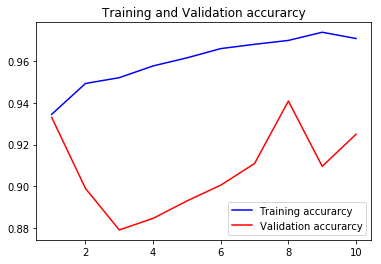

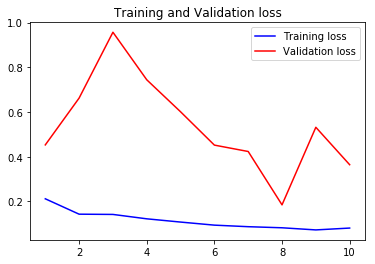

[INFO] Calculating model accuracy
590/590 [==============================] - 0s 662us/step
Test Accuracy: 92.49717593193054
[INFO] Saving model


In [44]:
Res_Plot_Test_Save('penta_CNN_Algorithm.h5')

# Transfer Learning Implementation

### Transfer Learning Advantages
Typically transfer learning enables us to build more robust models which can perform a wide variety of tasks.
* Helps solve complex real-world problems with several constraints
* Tackle problems like having little or almost no labeled data availability
* Ease of transfering knowledge from one model to another based on domains and tasks
* Provides a path towards achieving Artificial General Intelligence some day in the future!

**For References Check out**
[https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a]

### **Inception ModelV3**

##### Weights : Imagenet

In [45]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(128, 128, 3))
                             
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"]) 
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_105 (Conv2D)             (None, 63, 63, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_107 (BatchN (None, 63, 63, 32)   96          conv2d_105[0][0]                 
__________________________________________________________________________________________________
activation_207 (Activation)     (None, 63, 63, 32)   0           batch_normalization_107[0][0]    
____________________________________________________________________________________________

In [46]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/15
73/73 [==============================] - 17s 236ms/step - loss: 0.2261 - accuracy: 0.9332 - val_loss: 0.2442 - val_accuracy: 0.9285
Epoch 2/15
73/73 [==============================] - 11s 153ms/step - loss: 0.1798 - accuracy: 0.9393 - val_loss: 0.3228 - val_accuracy: 0.9134
Epoch 3/15
73/73 [==============================] - 11s 151ms/step - loss: 0.1651 - accuracy: 0.9437 - val_loss: 0.3769 - val_accuracy: 0.9180
Epoch 4/15
73/73 [==============================] - 11s 149ms/step - loss: 0.1576 - accuracy: 0.9449 - val_loss: 0.2783 - val_accuracy: 0.9285
Epoch 5/15
73/73 [==============================] - 11s 147ms/step - loss: 0.1499 - accuracy: 0.9473 - val_loss: 0.4285 - val_accuracy: 0.9180
Epoch 6/15
73/73 [==============================] - 11s 147ms/step - loss: 0.1479 - accuracy: 0.9474 - val_loss: 0.3702 - val_accuracy: 0.9150
Epoch 7/15
73/73 [==============================] - 11s 146ms/step - loss: 0.1442 - accuracy: 0.9491 - val_loss: 0.3619 - val_accuracy: 0.9262

[INFO] Plotting model accuracy and Loss


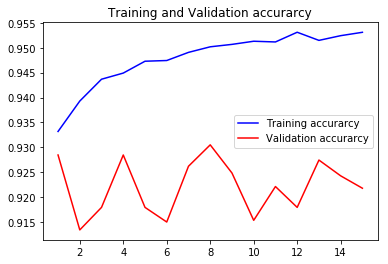

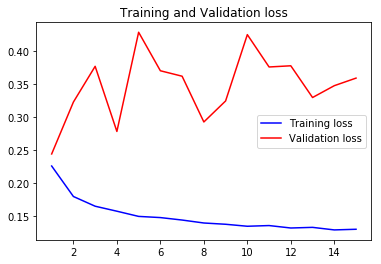

[INFO] Calculating model accuracy
590/590 [==============================] - 1s 2ms/step
Test Accuracy: 92.18078851699829
[INFO] Saving model


In [47]:
Res_Plot_Test_Save('Inception_ModelV3_(Imagenet_Weights).h5')

### **Resnet Model**

##### Weights : Imagenet

In [48]:
from keras.models import Model
from keras import applications
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

# Get the Resnet model so we can do transfer learning
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (128,128,3))
                             
# Add a global spatial average pooling layer
out = base_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_model.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"]) 
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [49]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=10, verbose=1
    )

Epoch 1/10
73/73 [==============================] - 43s 594ms/step - loss: 0.3359 - accuracy: 0.9286 - val_loss: 1.8612 - val_accuracy: 0.8786
Epoch 2/10
73/73 [==============================] - 17s 232ms/step - loss: 0.2697 - accuracy: 0.9322 - val_loss: 1.2277 - val_accuracy: 0.8942
Epoch 3/10
73/73 [==============================] - 17s 233ms/step - loss: 0.2252 - accuracy: 0.9334 - val_loss: 0.2193 - val_accuracy: 0.9292
Epoch 4/10
73/73 [==============================] - 17s 234ms/step - loss: 0.1833 - accuracy: 0.9374 - val_loss: 0.1844 - val_accuracy: 0.9386
Epoch 5/10
73/73 [==============================] - 17s 233ms/step - loss: 0.1651 - accuracy: 0.9415 - val_loss: 0.2206 - val_accuracy: 0.9294
Epoch 6/10
73/73 [==============================] - 17s 234ms/step - loss: 0.1449 - accuracy: 0.9471 - val_loss: 0.2814 - val_accuracy: 0.9220
Epoch 7/10
73/73 [==============================] - 17s 231ms/step - loss: 0.1388 - accuracy: 0.9500 - val_loss: 0.1791 - val_accuracy: 0.9412

[INFO] Plotting model accuracy and Loss


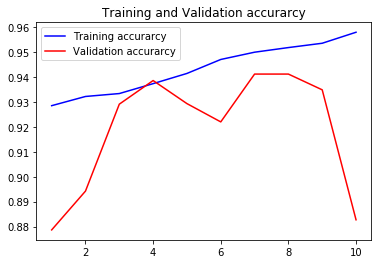

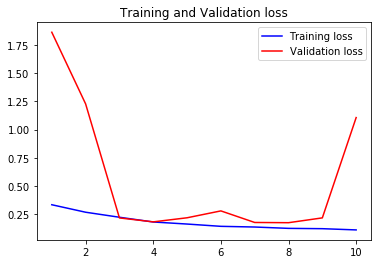

[INFO] Calculating model accuracy
590/590 [==============================] - 1s 2ms/step
Test Accuracy: 88.27119469642639
[INFO] Saving model


In [50]:
Res_Plot_Test_Save('Resnet_With_Imagenet_Weingts.h5')

### **VGG16 Model**

##### Weights : Imagenet

In [51]:
from keras.models import Model
from keras.applications import vgg16
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

# Get the Resnet model so we can do transfer learning
vgg = vgg16.VGG16(weights= None, include_top=False, input_shape= (128,128,3))
                             
# Add a global spatial average pooling layer
out = base_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_model.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"]) 
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [52]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=15, verbose=1
    )

Epoch 1/15
73/73 [==============================] - 45s 616ms/step - loss: 0.2068 - accuracy: 0.9419 - val_loss: 1.8725 - val_accuracy: 0.8768
Epoch 2/15
73/73 [==============================] - 18s 248ms/step - loss: 0.1319 - accuracy: 0.9531 - val_loss: 1.8145 - val_accuracy: 0.8765
Epoch 3/15
73/73 [==============================] - 17s 234ms/step - loss: 0.1167 - accuracy: 0.9580 - val_loss: 0.2849 - val_accuracy: 0.9201
Epoch 4/15
73/73 [==============================] - 17s 234ms/step - loss: 0.0995 - accuracy: 0.9632 - val_loss: 0.3933 - val_accuracy: 0.9093
Epoch 5/15
73/73 [==============================] - 17s 233ms/step - loss: 0.1003 - accuracy: 0.9613 - val_loss: 0.2348 - val_accuracy: 0.9307
Epoch 6/15
73/73 [==============================] - 17s 233ms/step - loss: 0.0935 - accuracy: 0.9652 - val_loss: 0.2477 - val_accuracy: 0.9330
Epoch 7/15
73/73 [==============================] - 17s 233ms/step - loss: 0.0891 - accuracy: 0.9656 - val_loss: 0.2094 - val_accuracy: 0.9410

[INFO] Plotting model accuracy and Loss


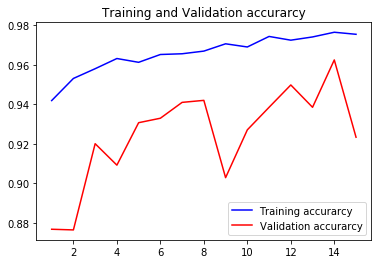

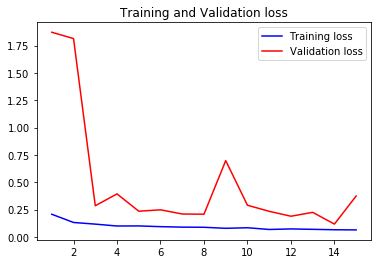

[INFO] Calculating model accuracy
590/590 [==============================] - 1s 2ms/step
Test Accuracy: 92.33897924423218
[INFO] Saving model


In [53]:
Res_Plot_Test_Save('VGG16_With_Imagenet_Weingts.h5')

### **VGG19 Model**

##### Weights : Imagenet

In [55]:
from keras.models import Model
from keras.applications import vgg19
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

# Get the Resnet model so we can do transfer learning
vgg = vgg19.VGG19(weights= None, include_top=False, input_shape= (128,128,3))
                             
# Add a global spatial average pooling layer
out = base_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_model.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"]) 
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=15, verbose=1
    )

Epoch 1/15
73/73 [==============================] - 44s 606ms/step - loss: 0.1331 - accuracy: 0.9554 - val_loss: 1.0015 - val_accuracy: 0.8789
Epoch 2/15
73/73 [==============================] - 17s 235ms/step - loss: 0.0941 - accuracy: 0.9664 - val_loss: 0.3136 - val_accuracy: 0.9234
Epoch 3/15
73/73 [==============================] - 17s 233ms/step - loss: 0.0835 - accuracy: 0.9695 - val_loss: 1.8487 - val_accuracy: 0.8788
Epoch 4/15
73/73 [==============================] - 17s 233ms/step - loss: 0.0769 - accuracy: 0.9722 - val_loss: 0.2221 - val_accuracy: 0.9384
Epoch 5/15
73/73 [==============================] - 17s 232ms/step - loss: 0.0716 - accuracy: 0.9730 - val_loss: 0.3567 - val_accuracy: 0.9181
Epoch 6/15
73/73 [==============================] - 17s 232ms/step - loss: 0.0691 - accuracy: 0.9754 - val_loss: 0.8188 - val_accuracy: 0.8985
Epoch 7/15
73/73 [==============================] - 17s 230ms/step - loss: 0.0640 - accuracy: 0.9762 - val_loss: 1.0726 - val_accuracy: 0.8877

In [ ]:
Res_Plot_Test_Save('VGG19_With_Imagenet_Weingts.h5')

# Transfer Learning Challenges
Transfer learning has immense potential and is a commonly required enhancement for existing learning algorithms. Yet, there are certain pertinent issues related to transfer learning that need more research and exploration. Apart from the difficulty of answering the questions of what, when, and how to transfer, negative transfer and transfer bounds present major challenges.
* Negative Transfer: The cases we have discussed so far talk about improvements in target tasks based on knowledge transfer from the source task. There are cases when transfer learning can lead to a drop in performance. Negative transfer refers to scenarios where the transfer of knowledge from the source to the target does not lead to any improvement, but rather causes a drop in the overall performance of the target task. There can be various reasons for negative transfer, such as cases when the source task is not sufficiently related to the target task, or if the transfer method could not leverage the relationship between the source and target tasks very well. Avoiding negative transfer is very important and requires careful investigation. In their work, Rosenstien and their co-authors present empirically how brute-force transfer degrades performance in target tasks when the source and target are too dissimilar. Bayesian approaches by Bakker and their co-authors, along with other techniques exploring clustering-based solutions to identify relatedness, are being researched to avoid negative transfers.
* Transfer Bounds: Quantifying the transfer in transfer learning is also very important, that affects the quality of the transfer and its viability. To gauge the amount for the transfer, Hassan Mahmud and their co-authors used Kolmogorov complexity to prove certain theoretical bounds to analyze transfer learning and measure relatedness between tasks. Eaton and their co-authors presented a novel graph-based approach to measure knowledge transfer. Detailed discussions of these techniques are outside the scope of this article. Readers are encouraged to explore more on these topics using the publications outlined in this section!